In [2]:
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
#suppressMessages(library(xts))
suppressMessages(library(forecast))

# Marriages Prediction

the data is fairly simple. Its the monthly number of transactions from 2010 to 2016. URL: https://data.qld.gov.au/dataset/marriages-by-month

1. Merge the data
2. Exploratory Analysis
3. Model Selection
4. Evaluate

# 1) Merge Dataset

In [4]:
df2016 <- read.csv('Marriages2016.csv')
df2015 <- read.csv('Marriages2015.csv')
df2014 <- read.csv('Marriages2014.csv')
df2013 <- read.csv('Marriages2013.csv')
df2012 <- read.csv('Marriages2012.csv')
df2011 <- read.csv('Marriages2011.csv')
df2010 <- read.csv('Marriages2010.csv')

In [5]:
df2016 <- cbind(year=2016,df2016)
df2015 <- cbind(year=2015,df2015)
df2014 <- cbind(year=2014,df2014)
df2013 <- cbind(year=2013,df2013)
df2012 <- cbind(year=2012,df2012)
df2012<- df2012[1:12,]
df2011 <- cbind(year=2011,df2011)
df2010 <- cbind(year=2010,df2010)

In [6]:
df <- do.call("rbind", list(df2010,df2011,df2012, df2013, df2014,df2015,df2016))

In [202]:
colSums(matrix(df$Transactions, nrow=12))

[1] 26824 25638 26277 25103 25076 23637 22900

In [7]:
final_test <- read.csv('Marriages2017.csv')

In [8]:
mts <- ts(df$Transactions, start = c(2010, 1), frequency=12)

In [16]:
test_mts <- ts(final_test$Transactions, start = c(2017, 1), frequency=12)

In [203]:
sum(test_mts)

[1] 22347

# 2) Exploring and Analysing the data

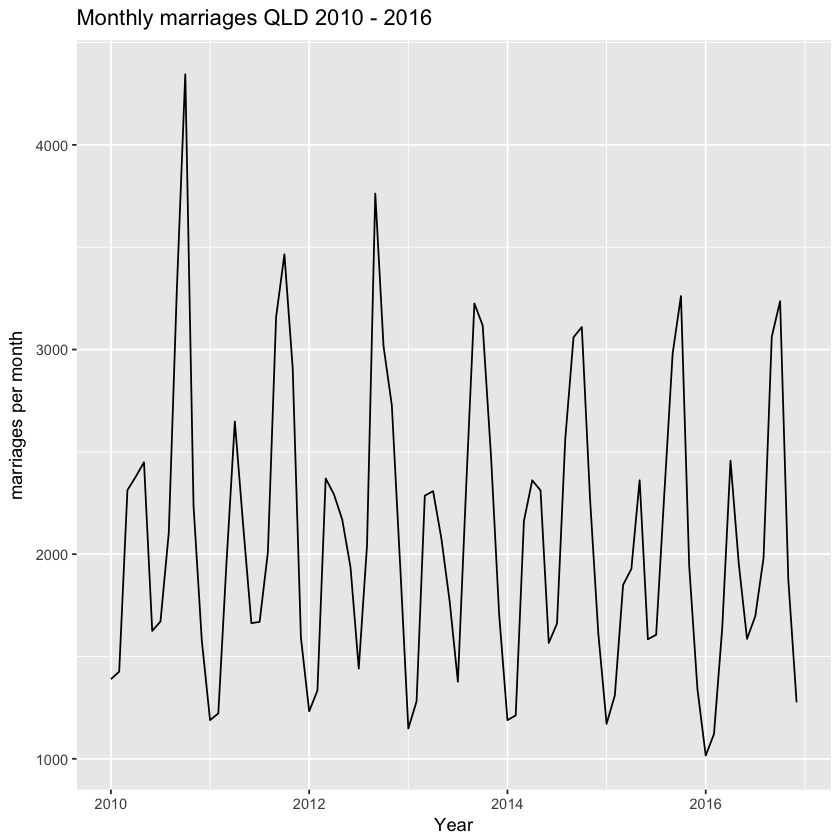

In [9]:
autoplot(mts) +
  ggtitle("Monthly marriages QLD 2010 - 2016") +
  ylab("marriages per month") + xlab("Year")

We can see that our time series has seasonality and a slight downward trend. Big spike in 2010 and getting smaller

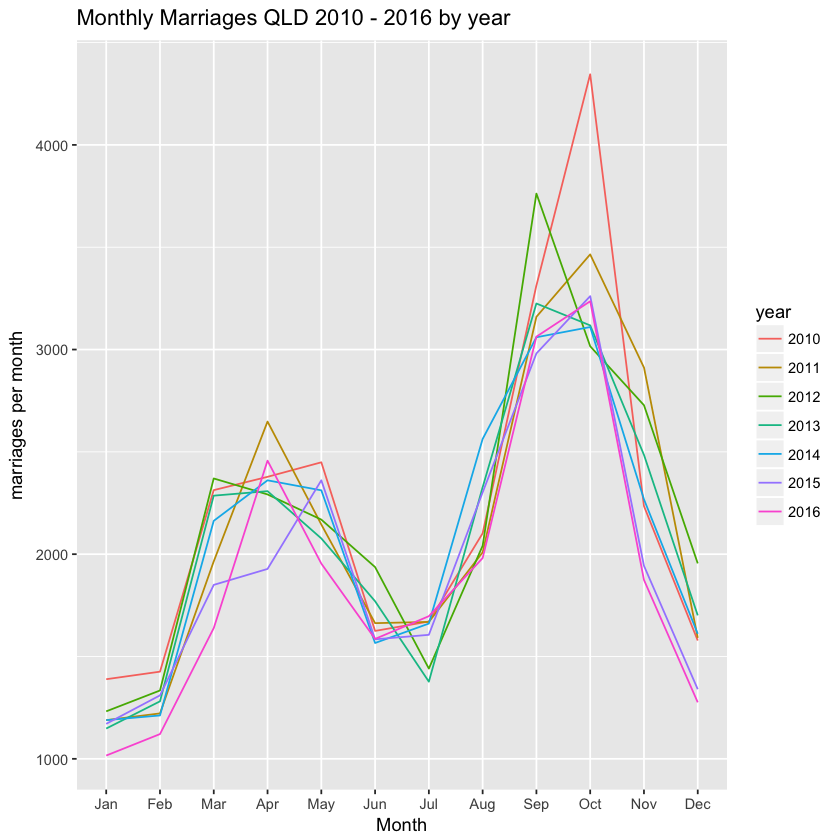

In [21]:
ggseasonplot(mts) + ggtitle("Monthly Marriages QLD 2010 - 2016 by year") + ylab("marriages per month")

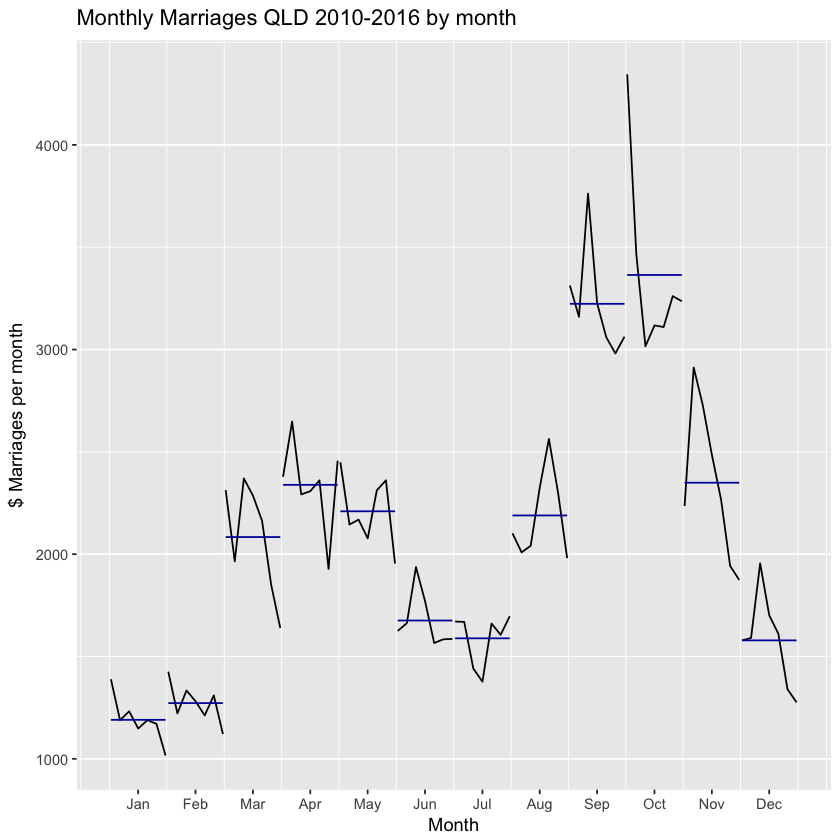

In [10]:
ggsubseriesplot(mts) + ylab("$ Marriages per month") +
  ggtitle("Monthly Marriages QLD 2010-2016 by month")

September, October are the most popular months. April marriages are on the rise.

### Time series decomposition 

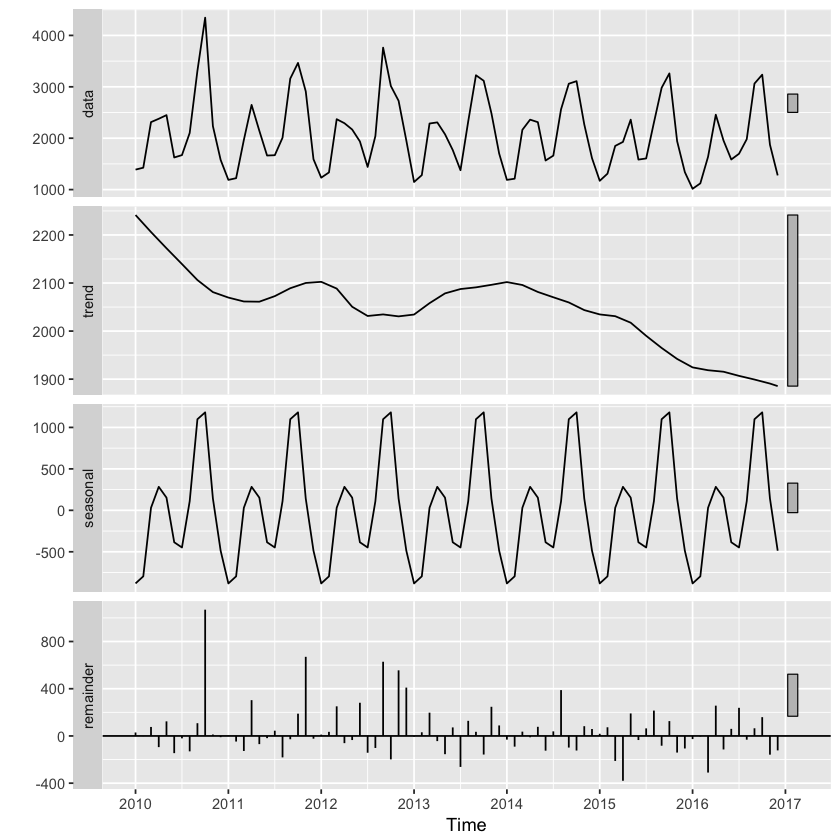

In [13]:
autoplot(stl(mts, s.window="periodic", robust=TRUE))

# 3) Model Selection

In [131]:
train <- window(mts, 2010, c(2015, 12))
test <- window(mts, 2016, c(2016, 12))

Lets fit a baseline model.

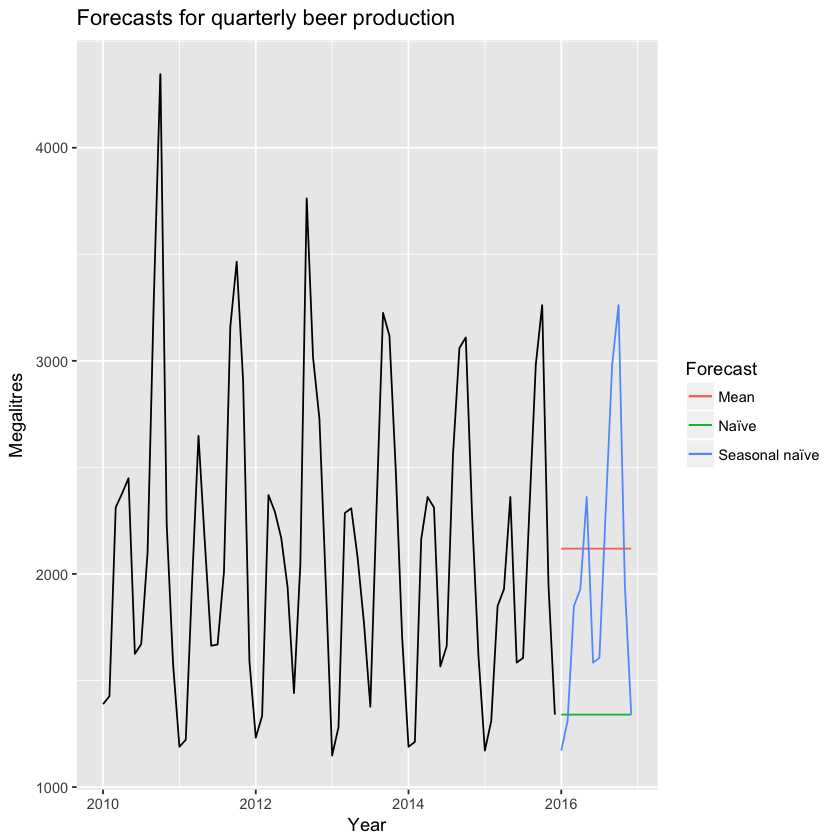

In [132]:
autoplot(train) +
  forecast::autolayer(meanf(train, h=12)$mean, series="Mean") +
  forecast::autolayer(naive(train, h=12)$mean, series="Naïve") +
  forecast::autolayer(snaive(train, h=12)$mean, series="Seasonal naïve") +
  ggtitle("Forecasts for quarterly beer production") +
  xlab("Year") + ylab("Megalitres") +
  guides(colour=guide_legend(title="Forecast"))

In [133]:
fit.sn <- snaive(train,h=12)

In [134]:
accuracy(forecast(fit.sn,h=12)$mean, test)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-61.41667,237.5726,178.75,-5.149735,10.09906,-0.5465098,0.4579452


RMSE of 237.57 will be the base line error that we will try to improve upon.

In [135]:
res <- residuals(fit.sn)

In [136]:
Box.test(res, lag=12, fitdf=4, type="Ljung")


	Box-Ljung test

data:  res
X-squared = 18.063, df = 8, p-value = 0.02076


In [137]:
e <- tsCV(mts, rwf, drift=TRUE, h=1)

In [138]:
sqrt(mean(e^2, na.rm=TRUE))

[1] 705.8944

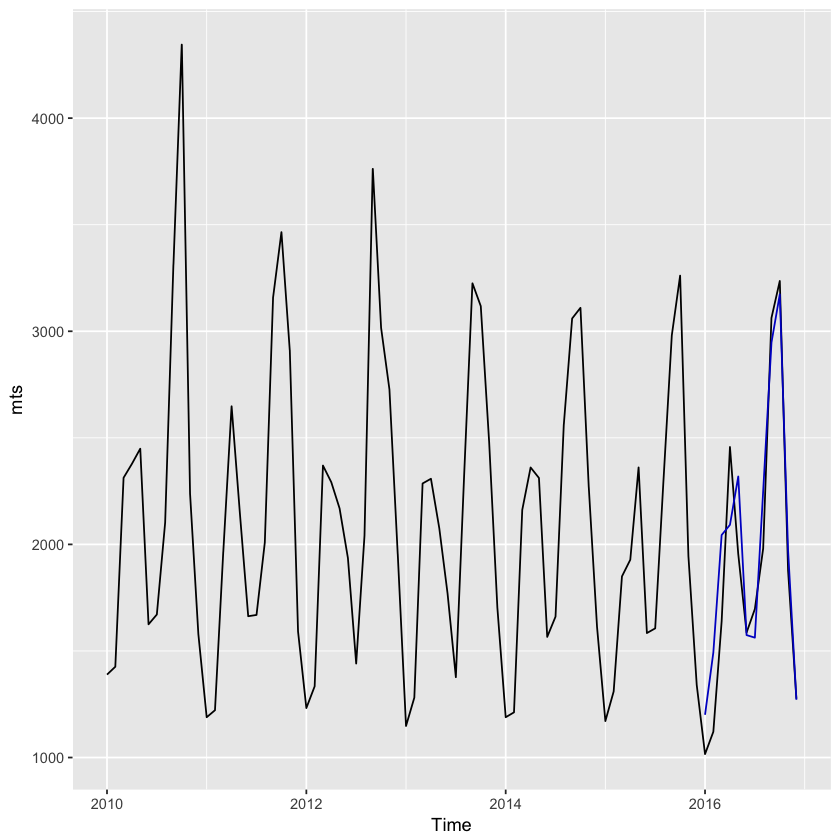

In [139]:
fit.nn <- nnetar(train, lambda=0)
autoplot(mts) + forecast::autolayer(forecast(fit.nn,h=12))

# ETS

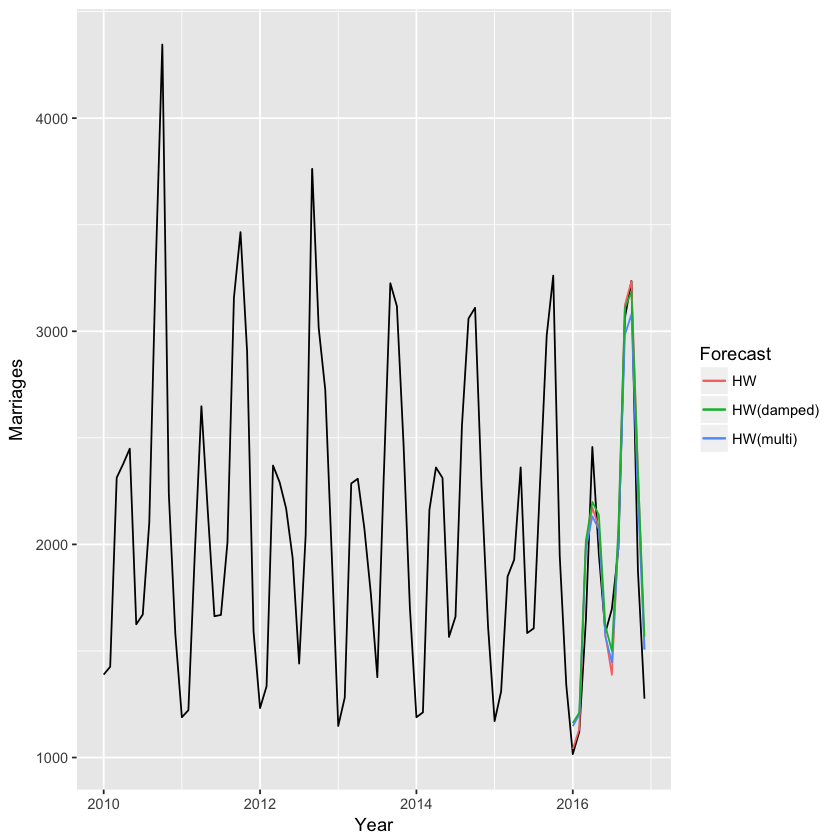

In [140]:
fit.ets1 <- hw(train,seasonal="additive",h=12)
fit.ets2 <- hw(train,seasonal="multiplicative",h=12)
fit.ets3 <- hw(train,damped=TRUE,seasonal="multiplicative",h=12)
autoplot(mts) +
  forecast::autolayer(fit.ets1$mean, series="HW") +
  forecast::autolayer(fit.ets2$mean, series="HW(multi)") +
  forecast::autolayer(fit.ets3$mean, series="HW(damped)") +
  xlab("Year") + ylab("Marriages") +
  guides(colour=guide_legend(title="Forecast"))

In [141]:
fit.sn <- snaive(train,h=12)
fit.aa <- auto.arima(train)

In [143]:
accuracy(forecast(fit.nn,h=12)$mean, test)
accuracy(forecast(fit.ets1,h=12)$mean, test)
accuracy(forecast(fit.ets2,h=12)$mean, test)
accuracy(forecast(fit.ets3,h=12)$mean, test)
accuracy(forecast(fit.sn,h=12)$mean, test)
accuracy(forecast(fit.aa, h=12)$mean, test)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-82.92477,244.8837,198.6852,-6.975369,11.91308,-0.3227084,0.5662129


,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-61.05745,223.8809,161.6909,-4.105219,9.170039,-0.1170756,0.4201511


,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-36.91145,208.3663,175.2195,-4.00506,10.10206,-0.1727883,0.4088003


,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-101.9767,228.6859,186.162,-7.268896,11.20716,-0.1850818,0.4300565


,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-61.41667,237.5726,178.75,-5.149735,10.09906,-0.5465098,0.4579452


,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-19.70067,235.3983,174.6467,-3.019327,9.730234,-0.5024742,0.4386047


In [167]:
Combination <- (
                forecast(fit.aa,h=12)$mean + 
                forecast(fit.ets2,h=12)$mean + 
                forecast(fit.ets1,h=12)$mean 
                )/3

In [164]:
accuracy(Combination, test)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-54.91155,203.2417,168.5929,-4.599625,9.820874,-0.3305106,0.3945902


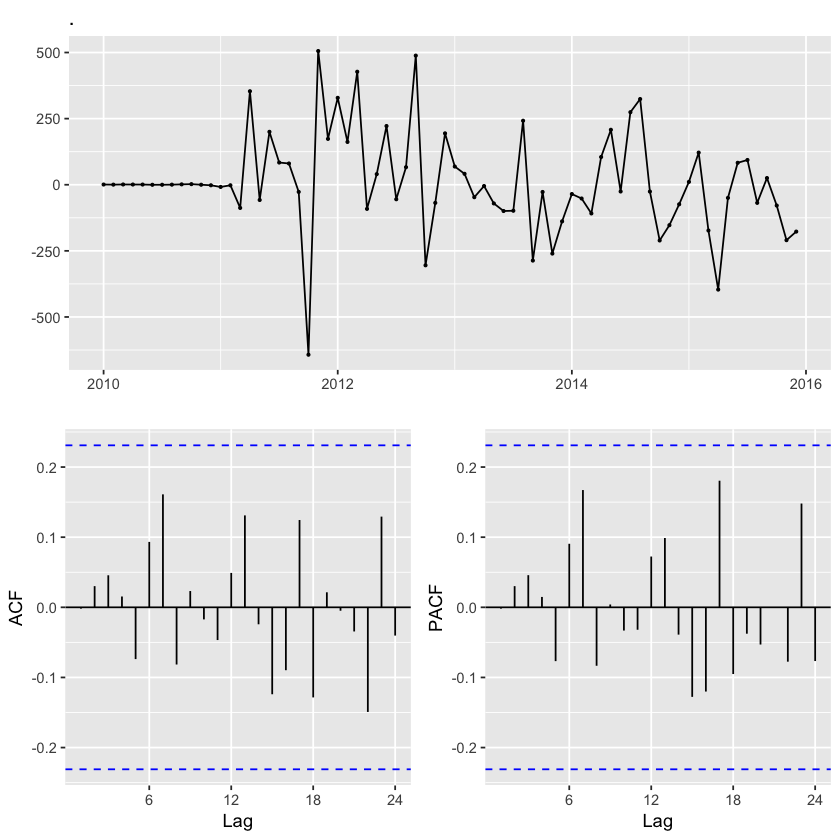

In [32]:
train %>%
  Arima(order=c(2,1,2), seasonal=c(3,1,1)) %>%
  residuals %>%
  ggtsdisplay

In [33]:
fit.arima1 <- Arima(train,order=c(2,1,3), seasonal=c(3,1,1))

In [34]:
fcast.arima <- forecast(fit.arima1, h=12)$mean
fcast.ets <- forecast(fit.ets2,h=12)$mean

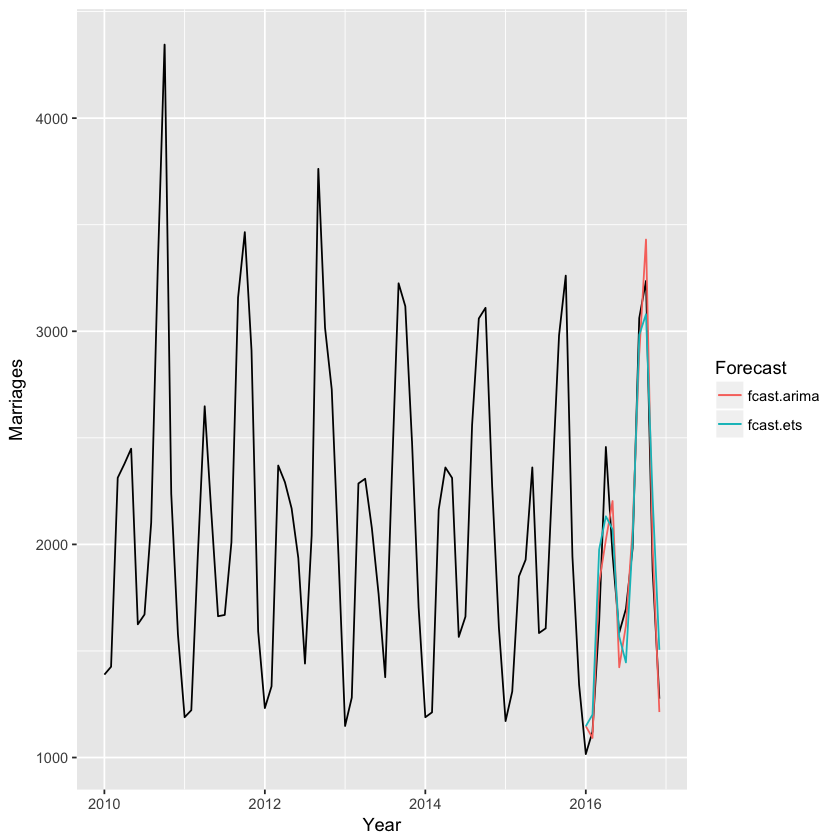

In [35]:
autoplot(mts) +
  forecast::autolayer(fcast.arima) +
  forecast::autolayer(fcast.ets) +
  xlab("Year") + ylab("Marriages") +
  guides(colour=guide_legend(title="Forecast"))

In [36]:
accuracy(fcast.arima, test)
accuracy(fcast.ets, test)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-1.697471,188.4264,157.6635,-0.632198,8.22714,-0.6236964,0.3392899


,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-36.91145,208.3663,175.2195,-4.00506,10.10206,-0.1727883,0.4088003


# Real data validation

our best performing model was ARIMA. Now that we have the lets test few of the best models and see which perfomed well on an actual data.

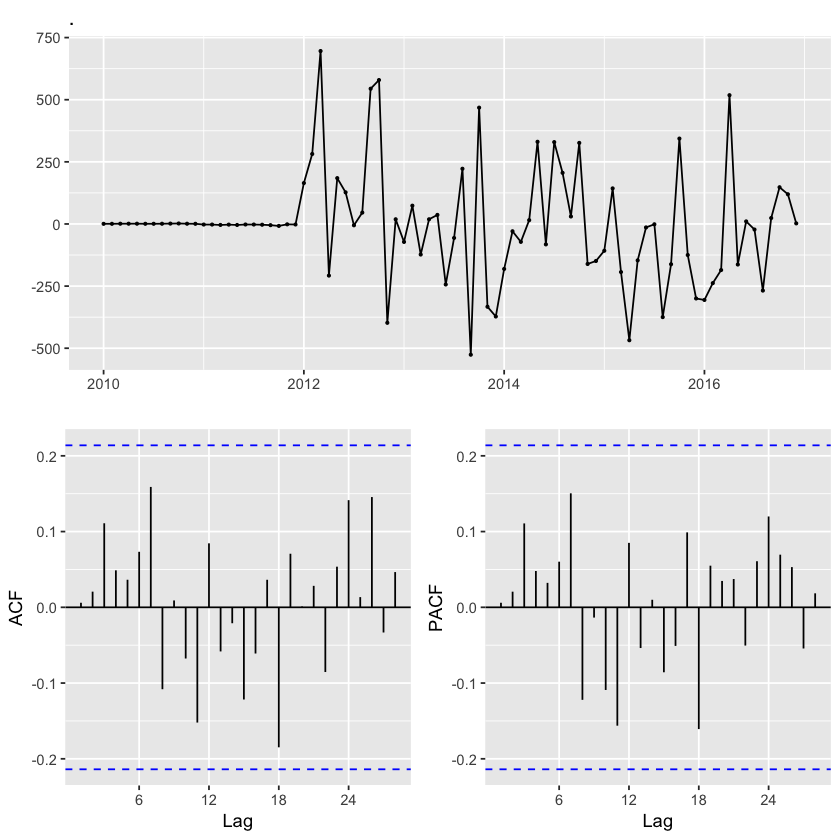

In [81]:
mts %>%
  Arima(order=c(2,0,1), seasonal=c(0,2,1)) %>%
  residuals %>%
  ggtsdisplay

In [119]:
fit.arima <- Arima(mts,order=c(2,0,1), seasonal=c(0,2,1))
fcast.arima <- forecast(fit.arima, h=12)$mean

In [121]:
accuracy(fcast.arima, test_mts)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,7.333803,169.5981,117.7322,0.60398,5.465141,-0.4602135,0.2385778


In [45]:
fit.ets2 <- hw(mts,seasonal="multiplicative",h=12)
fcast.ets <- forecast(fit.ets2,h=12)$mean
accuracy(fcast.ets, test_mts)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-3.616482,261.6685,204.4421,-2.012729,10.48331,-0.01131626,0.4259573


In [47]:
fit.sn <- snaive(mts,h=12)
fcast.sn <- forecast(fit.sn,h=12)$mean
accuracy(fcast.sn, test_mts)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-46.08333,201.6207,125.5833,-2.495625,5.844172,-0.3154462,0.2335737


In [58]:
fit.aa

Series: mts 
ARIMA(0,0,1)(0,1,1)[12] with drift 

Coefficients:
          ma1     sma1    drift
      -0.3613  -0.2471  -4.2899
s.e.   0.1019   0.1706   1.1931

sigma^2 estimated as 57880:  log likelihood=-495.86
AIC=999.72   AICc=1000.32   BIC=1008.83

In [172]:
fit.aa <- auto.arima(mts)
fit.nn <- nnetar(mts, lambda=0)
fit.ets1 <- hw(mts,seasonal="additive",h=12)
fit.ets3 <- hw(mts,damped=TRUE,seasonal="multiplicative",h=12)

In [173]:
fcast.aa <- forecast(fit.aa,h=12)$mean
fcast.nn <- forecast(fit.nn,h=12)$mean
fcast.ets1 <- forecast(fit.ets1,h=12)$mean
fcast.ets3 <- forecast(fit.ets3,h=12)$mean

In [174]:
accuracy(fcast.aa, test_mts)
accuracy(fcast.nn, test_mts)
accuracy(fcast.ets1, test_mts)
accuracy(fcast.ets3, test_mts)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-3.420955,199.7954,122.4858,-0.3856458,5.394174,-0.3648737,0.2563777


,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-57.40336,200.2661,141.7511,-3.633754,7.015451,-0.2021591,0.258535


,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-22.20203,274.4878,207.9876,-1.729722,10.54787,0.04645478,0.422177


,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-63.76763,265.9087,223.0454,-5.430441,12.09636,0.0251659,0.426513


In [188]:
combo1 <- (fcast.nn + fcast.arima  + fcast.sn)/3

In [189]:
accuracy(combo1, test_mts)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-32.05096,183.3888,117.4103,-1.8418,5.504042,-0.3084268,0.2219165


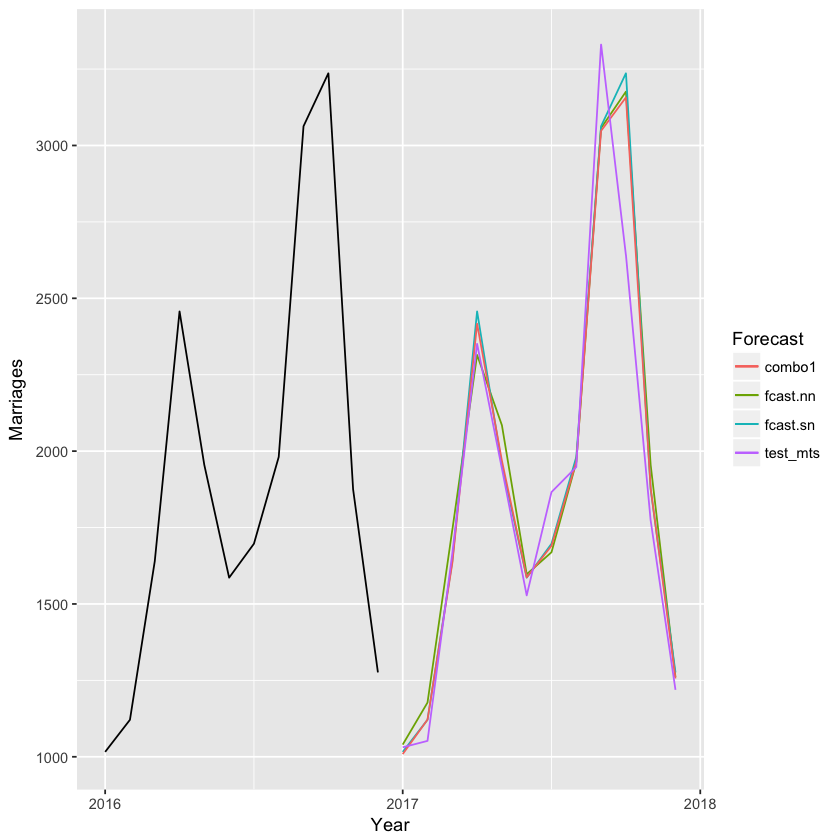

In [190]:
autoplot(test) +
  forecast::autolayer(fcast.nn) +
  forecast::autolayer(fcast.sn) +
  forecast::autolayer(combo1) +
  forecast::autolayer(test_mts) +
  xlab("Year") + ylab("Marriages") +
  guides(colour=guide_legend(title="Forecast"))

# Conclusion

The best we could do is +/- 190 or 183 using the ensemble. 

In [214]:
fcast.nn - test_mts

             Jan         Feb         Mar         Apr         May         Jun
2017    8.827647  125.420104   76.706160  -36.381432  141.770408   69.070052
             Jul         Aug         Sep         Oct         Nov         Dec
2017 -196.830775   15.632995 -272.874258  533.963563  181.927376   41.608534

We can see that we over forecasted September by 272 and underforcasted Oct by 533

These do predicted badly in the peak season but if we actually examine the season as a whole we only missed by 260 marriages for the two months.

People plan their marriages. If not in september they will tie the knot in october. 

It will be interesting to see if the passing of same-sex marriage will have any effect. It could be argued that we should expect lots of new marriages in 2018 dues to backlog of people waiting to get married and then a steady rate of same-sex marriages. 

This will p

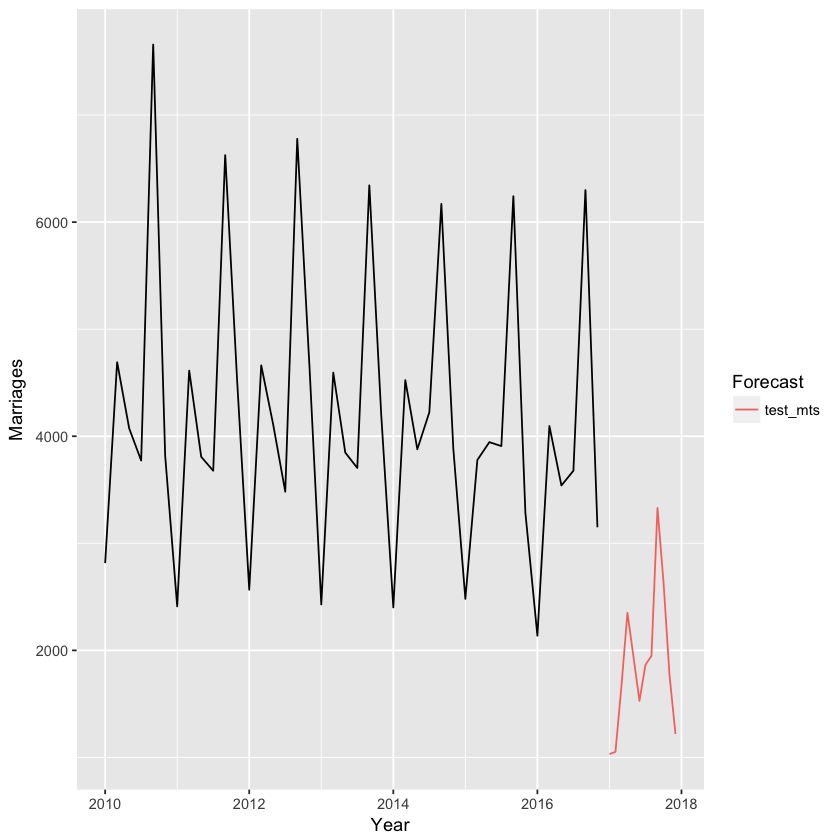

In [216]:
autoplot(mts) +
  forecast::autolayer(test_mts) +
  xlab("Year") + ylab("Marriages") +
  guides(colour=guide_legend(title="Forecast"))